# FP8 Quantization with AMD Quark for vLLM 

Quantization can effectively reduce memory and bandwidth usage, accelerate computation and improve throughput while with minimal accuracy loss. 

[vLLM](https://docs.vllm.ai/en/latest/) is an open-source library designed to deliver high throughput and low latency for large language model (LLM) inference. It optimizes text generation workloads by efficiently batching requests and making full use of GPU resources, empowering developers to manage complex tasks like code generation and large-scale conversational AI.

vLLM can leverage Quark, the flexible and powerful quantization toolkit, to produce performant quantized models to run on AMD GPUs. Quark has specialized support for quantizing large language models with weight, activation and kv-cache quantization and cutting-edge quantization algorithms like AWQ, GPTQ, Rotation and SmoothQuant.

This tutorial guides you through setting up Quark and quantize LLM models to FP8, then running the FP8 model on AMD Instinct™ GPUs using the ROCm software stack. Learn how to configure Quark parameters, to achieve different model precision, ao as to performance with different quantization algorithms.

# 📘 Supported Models

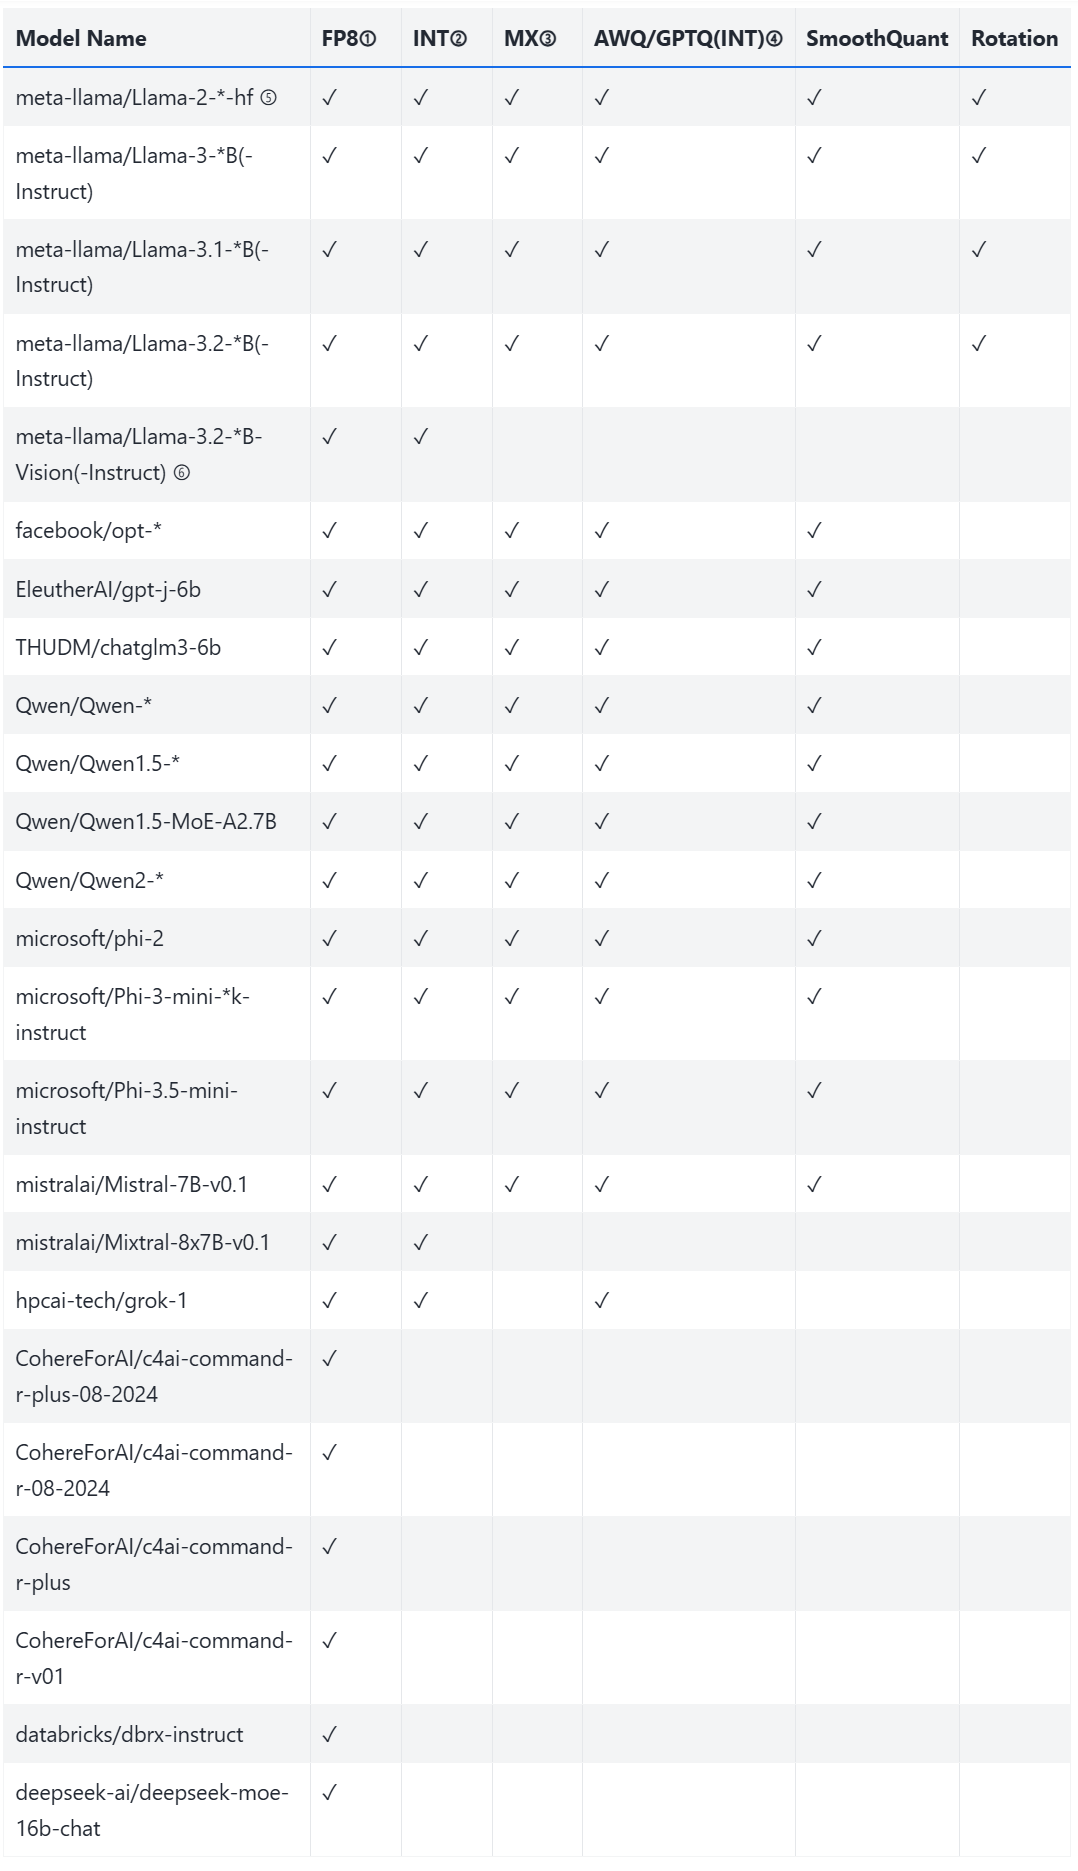
**Figure 1.** Supported models in the AMD Quark tool.

## 🔍 Notes

- **FP8**: Refers to OCP `fp8_e4m3` data type quantization.
- **INT**: Includes `INT8`, `UINT8`, `INT4`, and `UINT4` quantization types.
- **MX**: Includes custom OCP data types such as:
  - `MXINT8`
  - `MXFP8E4M3`
  - `MXFP8E5M2`
  - `MXFP4`
  - `MXFP6E3M2`
  - `MXFP6E2M3`
- **GPTQ**: Only supports `QuantScheme` values of `PerGroup` and `PerChannel`.
- `*` indicates different model sizes (e.g., `7B`, `13B`, etc.).
- `meta-llama/Llama-3.2-*B-Vision` models: Only the **language components** are quantized; vision modules are excluded.


## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Software

* **ROCm 6.2 or 6.3**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

   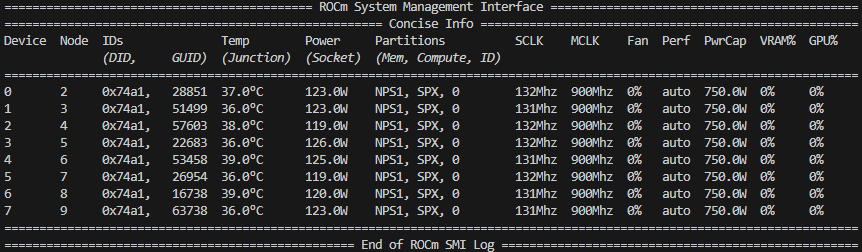


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly with:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access the [Meta Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B).

<a id="env-setup"></a>
## 1. Environment setup with Docker and ROCm

Launch the Docker container. From your host machine, run this command:

``` bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  rocm/vllm-dev:main
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).

<a id="launch-jupyter"></a>
## 2. Launch Jupyter Notebooks in the container

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


<a id="install-deps"></a>
## 3. Installing dependencies

Next we will install CMake, and Quark itself. We’ve selected the CPU wheel of PyTorch here so that Quark will run on laptops without GPUs, which is slower, but fine for trying out Quark. We will install Quark from PyPI, which will pull in required dependencies.

Run the following commands inside the Jupyter notebook running within the Docker container:

In [ ]:
!pip install cmake amd-quark==0.8.1
!pip install ipython ipywidgets 
!pip install huggingface_hub
!pip install evaluate>=0.4.0
!pip install accelerate datasets pillow pillow transformers zstandard lm-eval

### Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1-8B. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1-8B-Instruct](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct). Tokens typically start with "hf_".

Run the following interactive block in your Jupyter notebook to set up the token:

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


Verify that your token was accepted correctly:

In [ ]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")


# Quantization Process
After installing Quark, we will use an example to illustrate how to use Quark.
The Quark quantization process can be listed for 5 steps as below:

1. Load the model
2. Prepare the calibration dataloader
3. Set the quantization configuration
4. Quantize the model and export
5. Evaluation in vLLM

Quark uses Transformers to fetch model and tokenizer.

# 1. Load the Model
Quark uses Transformers to fetch model and tokenizer.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
MAX_SEQ_LEN = 512

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, device_map="auto", torch_dtype="auto",
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, model_max_length=MAX_SEQ_LEN)
tokenizer.pad_token = tokenizer.eos_token

# 2. Prepare the Calibration Dataloader
Quark uses the PyTorch Dataloader to load calibration data. For more details about how to use calibration datasets efficiently, please refer to Adding Calibration Datasets.

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_CALIBRATION_DATA = 512

# Load the dataset and get calibration data.
dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
text_data = dataset["text"][:NUM_CALIBRATION_DATA]

tokenized_outputs = tokenizer(text_data, return_tensors="pt",
    padding=True, truncation=True, max_length=MAX_SEQ_LEN)
calib_dataloader = DataLoader(tokenized_outputs['input_ids'],
    batch_size=BATCH_SIZE, drop_last=True)

# 3. Set the Quantization Configuration

Start by dowloaidng example config files and necessary packages to download and unzip.

In [ ]:

%%bash
#Install unzip and wget
apt-get update
apt-get install -y unzip wget

# Download and unzip AMD Quark examples
wget -O amd_quark-0.8.1.zip https://download.amd.com/opendownload/Quark/amd_quark-0.8.1.zip
unzip -o amd_quark-0.8.1.zip


We need to set the quantization configuration, you can check quark config guide for further details. Here we use FP8 per-tensor quantization on weight, activation, kv-cache and the quantization algorithm is AutoSmoothQuant.

In [ ]:
from quark.torch.quantization import (Config, QuantizationConfig,
                                     FP8E4M3PerTensorSpec,
                                     load_quant_algo_config_from_file)

# Define fp8/per-tensor/static spec.
FP8_PER_TENSOR_SPEC = FP8E4M3PerTensorSpec(observer_method="min_max",
    is_dynamic=False).to_quantization_spec()

# Define global quantization config, input tensors and weight apply FP8_PER_TENSOR_SPEC.
global_quant_config = QuantizationConfig(input_tensors=FP8_PER_TENSOR_SPEC,
    weight=FP8_PER_TENSOR_SPEC)

# Define quantization config for kv-cache layers, output tensors apply FP8_PER_TENSOR_SPEC.
KV_CACHE_SPEC = FP8_PER_TENSOR_SPEC
kv_cache_layer_names_for_llama = ["*k_proj", "*v_proj"]
kv_cache_quant_config = {name :
    QuantizationConfig(input_tensors=global_quant_config.input_tensors,
                       weight=global_quant_config.weight,
                       output_tensors=KV_CACHE_SPEC)
    for name in kv_cache_layer_names_for_llama}
layer_quant_config = kv_cache_quant_config.copy()

# Define algorithm config by config file.
LLAMA_AUTOSMOOTHQUANT_CONFIG_FILE = 'amd_quark-0.8.1/examples/torch/language_modeling/llm_ptq/models/llama/autosmoothquant_config.json'
algo_config = load_quant_algo_config_from_file(LLAMA_AUTOSMOOTHQUANT_CONFIG_FILE)

EXCLUDE_LAYERS = ["lm_head"]
quant_config = Config(
    global_quant_config=global_quant_config,
    layer_quant_config=layer_quant_config,
    kv_cache_quant_config=kv_cache_quant_config,
    exclude=EXCLUDE_LAYERS,
    algo_config=algo_config)

# 4. Quantize the Model
Then we can apply the quantization. After quantizing, we need to freeze the quantized model first before exporting. 

In [ ]:
import torch
from quark.torch import ModelQuantizer
from quark.torch.export import JsonExporterConfig

# Apply quantization.
quantizer = ModelQuantizer(quant_config)
quant_model = quantizer.quantize_model(model, calib_dataloader)

# Freeze quantized model to export.
freezed_model = quantizer.freeze(model)

# 5. Export the Model
We need to export model with format of HuggingFace safetensors, you can refer to HuggingFace format exporting for more exporting format details.

In [ ]:
from quark.torch.quantization.config.config import Config
from quark.torch.export.config.config import ExporterConfig
from quark.shares.utils.log import ScreenLogger
from quark.torch import ModelExporter
from transformers import AutoTokenizer
from torch import nn
from pathlib import Path
from typing import List, Optional, Dict, Any
import torch
import json
import sys
import os


logger = ScreenLogger(__name__)
# Define export config.
LLAMA_KV_CACHE_GROUP = ["*k_proj", "*v_proj"]
export_config = ExporterConfig(json_export_config=JsonExporterConfig())
export_config.json_export_config.kv_cache_group = LLAMA_KV_CACHE_GROUP
export_path= "Llama-3.1-8B-Instruct-FP8"


EXPORT_DIR = MODEL_ID.split("/")[1] + "-FP8"
exporter = ModelExporter(config=export_config, export_dir=EXPORT_DIR)
# with torch.no_grad():
#     exporter.export_safetensors_model(freezed_model,quant_config=quant_config, tokenizer=tokenizer)

model = exporter.get_export_model(freezed_model, quant_config=quant_config, custom_mode="quark", add_export_info_for_hf=True)
model.save_pretrained(export_path)
try:
    # TODO: Having trust_remote_code=True by default in our codebase is dangerous.
    model_type = 'llama'
    use_fast = True if model_type in ["grok", "cohere", "olmo"] else False
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=use_fast)
    tokenizer.save_pretrained(export_path)
except Exception as e:
    logger.error(f"An error occurred when saving tokenizer: {e}.  You can try to save the tokenizer manually")
exporter.reset_model(model=model)
logger.info(f"hf_format quantized model exported to {export_path} successfully.")

# 6. Evaluation in vLLM
Now, you can load and run the Quark quantized model directly through the LLM entrypoint:

In [ ]:
from vllm import LLM, SamplingParams

# Sample prompts.
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)

# Create an LLM.
llm = LLM(model="Llama-3.1-8B-Instruct-FP8",
          kv_cache_dtype='fp8',quantization='quark')
# Generate texts from the prompts. The output is a list of RequestOutput objects
# that contain the prompt, generated text, and other information.
outputs = llm.generate(prompts, sampling_params)
# Print the outputs.
print("\nGenerated Outputs:\n" + "-" * 60)
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt:    {prompt!r}")
    print(f"Output:    {generated_text!r}")
    print("-" * 60)

# clean up and release GPU 
del llm

# Step 2: Call garbage collector
import gc
gc.collect()

# Step 3: If using PyTorch backend, clear CUDA (optional but helpful)
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

Or, you can use lm_eval to evaluate accuracy:

In [ ]:
!lm_eval --model vllm \
  --model_args pretrained=Llama-3.1-8B-Instruct-FP8,kv_cache_dtype='fp8',quantization='quark' \
  --tasks gsm8k

# Quark Quantization Script
In addition to the example of Python API above, Quark also offers a quantization script to quantize large language models more conveniently. It supports quantizing models with variety of different quantization schemes and optimization algorithms. It can export the quantized model and run evaluation tasks on the fly. With the script, the example above can be (you can change output dir via --output_dir option):

In [ ]:
import os
os.chdir("./amd_quark-0.8.1/examples/torch/language_modeling/llm_ptq/")
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --output_dir ./Llama-3.1-8B-Instruct-FP8 \
                          --quant_scheme w_fp8_a_fp8 \
                          --kv_cache_dtype fp8 \
                          --quant_algo autosmoothquant \
                          --num_calib_data 512 \
                          --model_export hf_format \
                          --tasks gsm8k

# Best Practices for Post-Training Quantization (PTQ)
This topic outlines best practices for Post-Training Quantization (PTQ) in AMD Quark PyTorch. It provides guidance on fine-tuning your quantization strategy to address accuracy degradation issues. Below, we use the model meta-llama/Llama-3.1-8B-Instruct and code files from Quark/examples/torch/language_modeling/llm_ptq as an example to demonstrate the methodology.
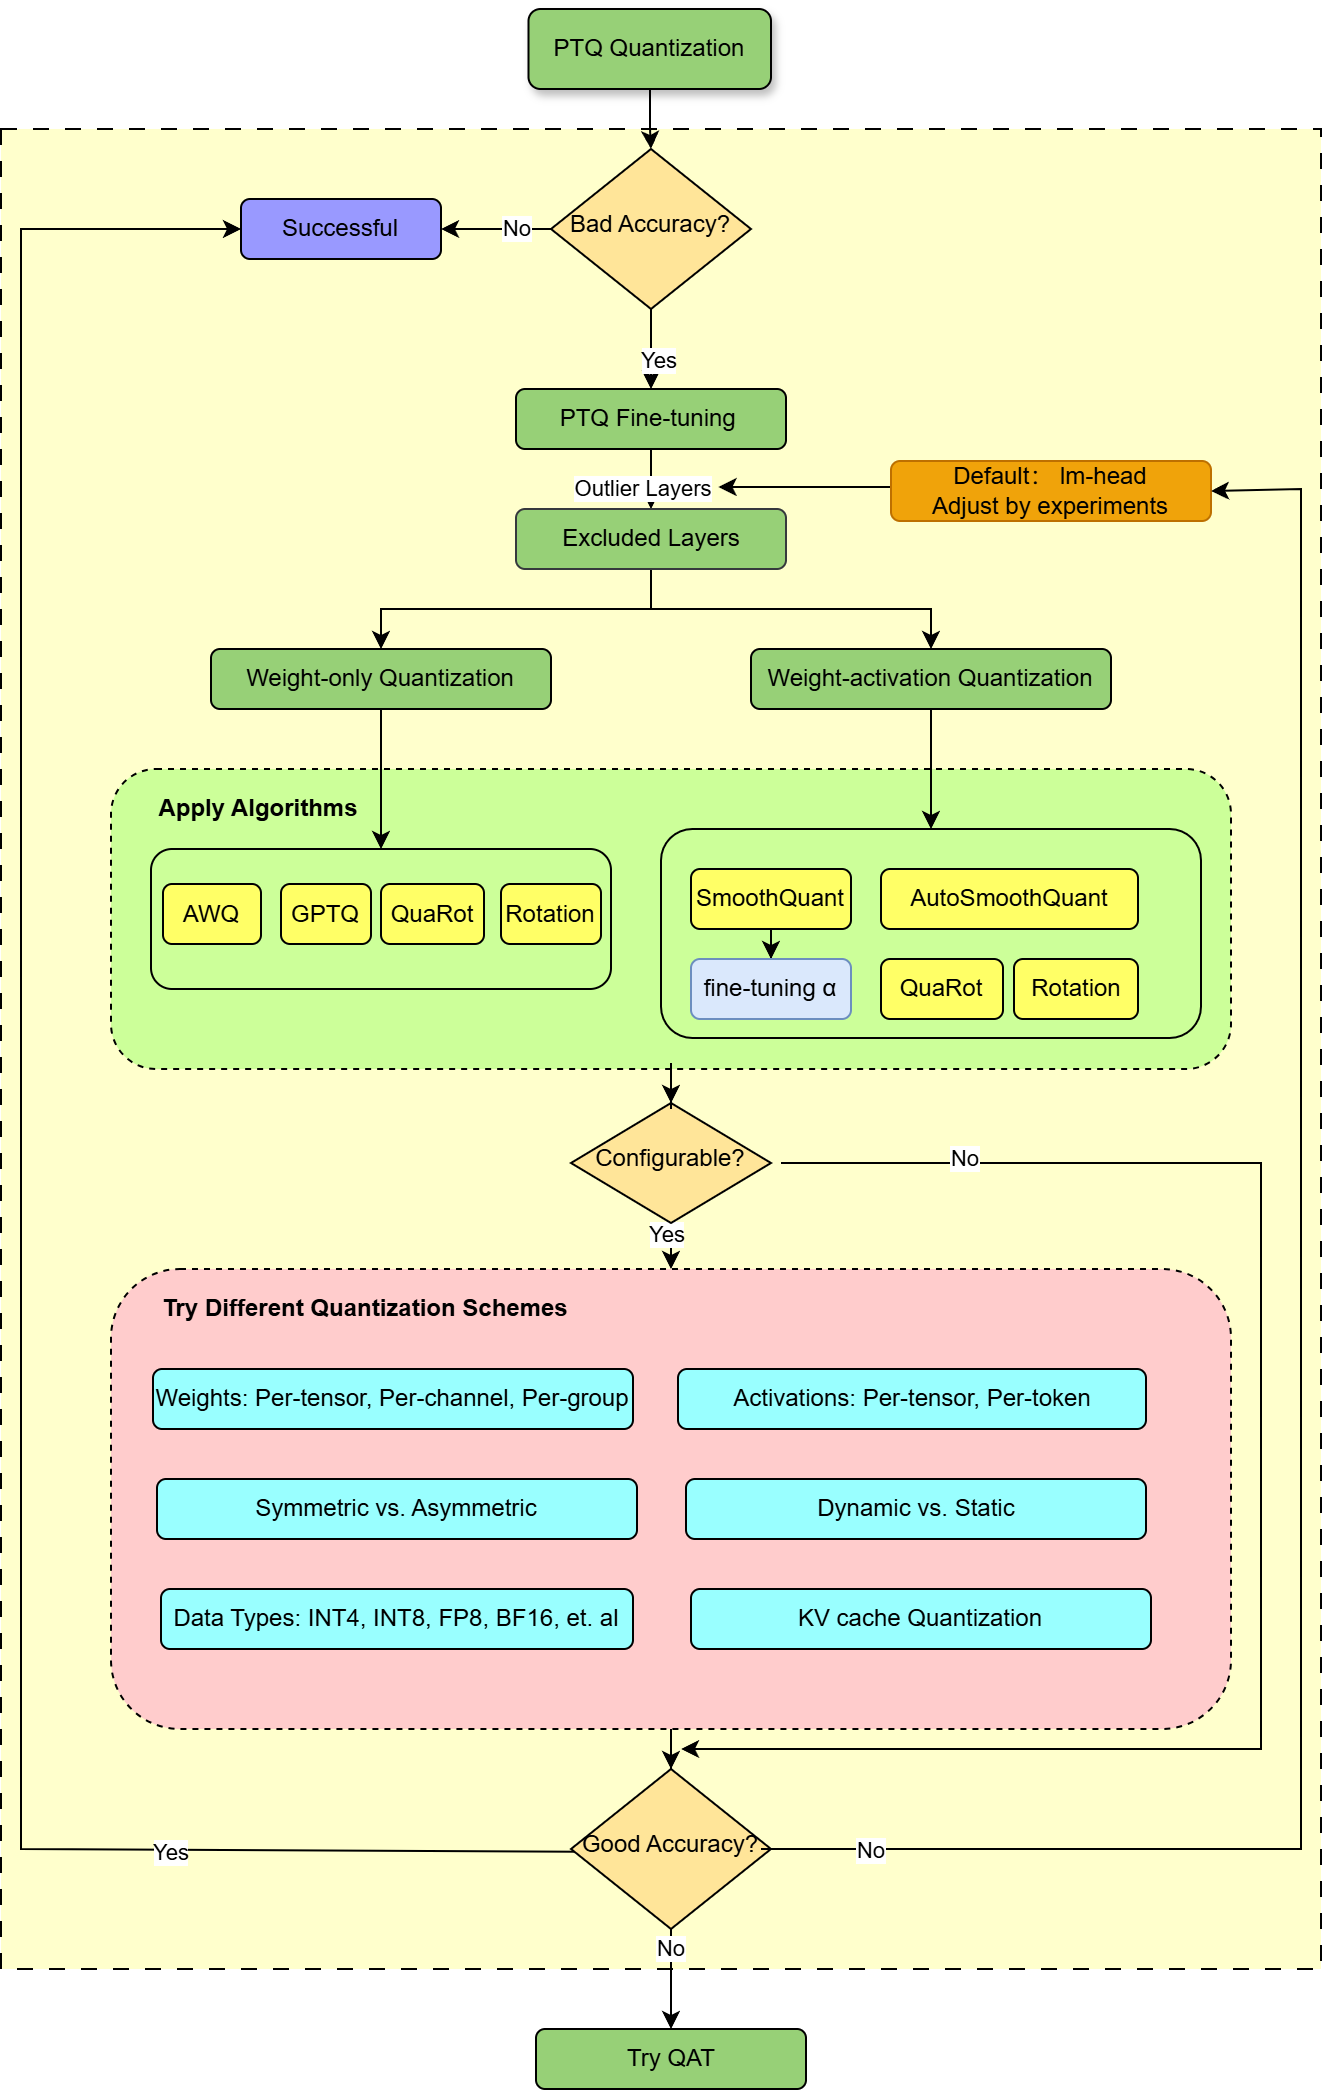
                              Figure 2. Best Practices for AMD Quark Torch Quantization



Pls confirm the current working directory is in "./amd_quark-0.8.1/examples/torch/language_modeling/llm_ptq/".
If not, pls switch to this one. 

In [ ]:
exclude_layers="*lm_head *layers.0.mlp.down_proj"
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --quant_scheme w_fp8_a_fp8 \
                          --exclude_layers $exclude_layers 

## Apply Various Quantization Algorithms
AMD Quark supports various quantization algorithms specifically designed for Large Language Models (LLMs). You can experiment with the following algorithms to enhance accuracy. 

Note: The model precision is not limited in FP8 in this section.

### AWQ (Activation-aware Weight Quantization)
AWQ determines optimal scaling factors for smooth through grid search and is widely used in low-bit weight only quantization (e.g. W4 quantization with group-size 128). The algorithm can be used in the following command.

In [ ]:
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --quant_scheme w_uint4_per_group_asym \
                          --group_size 128 \
                          --dataset pileval_for_awq_benchmark \
                          --quant_algo awq

### AutoSmoothQuant
AutoSmoothQuant enhances SmoothQuant by automatically selecting the optimal 
 values for each layer, guided by the Mean Squared Error (MSE) loss across blocks.

In [ ]:
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --quant_scheme w_int8_a_int8_per_tensor_sym \
                          --dataset pileval_for_awq_benchmark \
                          --quant_algo autosmoothquant

### QuaRot
QuaRot eliminates activation outliers using a rotation technique (Hadamard transform). AMD Quark supports QuaRot algorithm, which can be used as follows.

In [ ]:
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --quant_scheme w_int8_a_int8_per_tensor_sym \
                          --pre_quantization_optimization quarot

### Rotation
QuaRot employs an online Hadamard transform in its algorithm, requiring kernel support for hardware deployment. Inspired by QuaRot and QServer, AMD Quark introduces the “Rotation” method, which enhances accuracy without requiring kernel modifications.

In [ ]:
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.1-8B-Instruct \
                          --quant_scheme w_int8_a_int8_per_tensor_sym \
                          --pre_quantization_optimization rotation

Successful evaluation result as below:

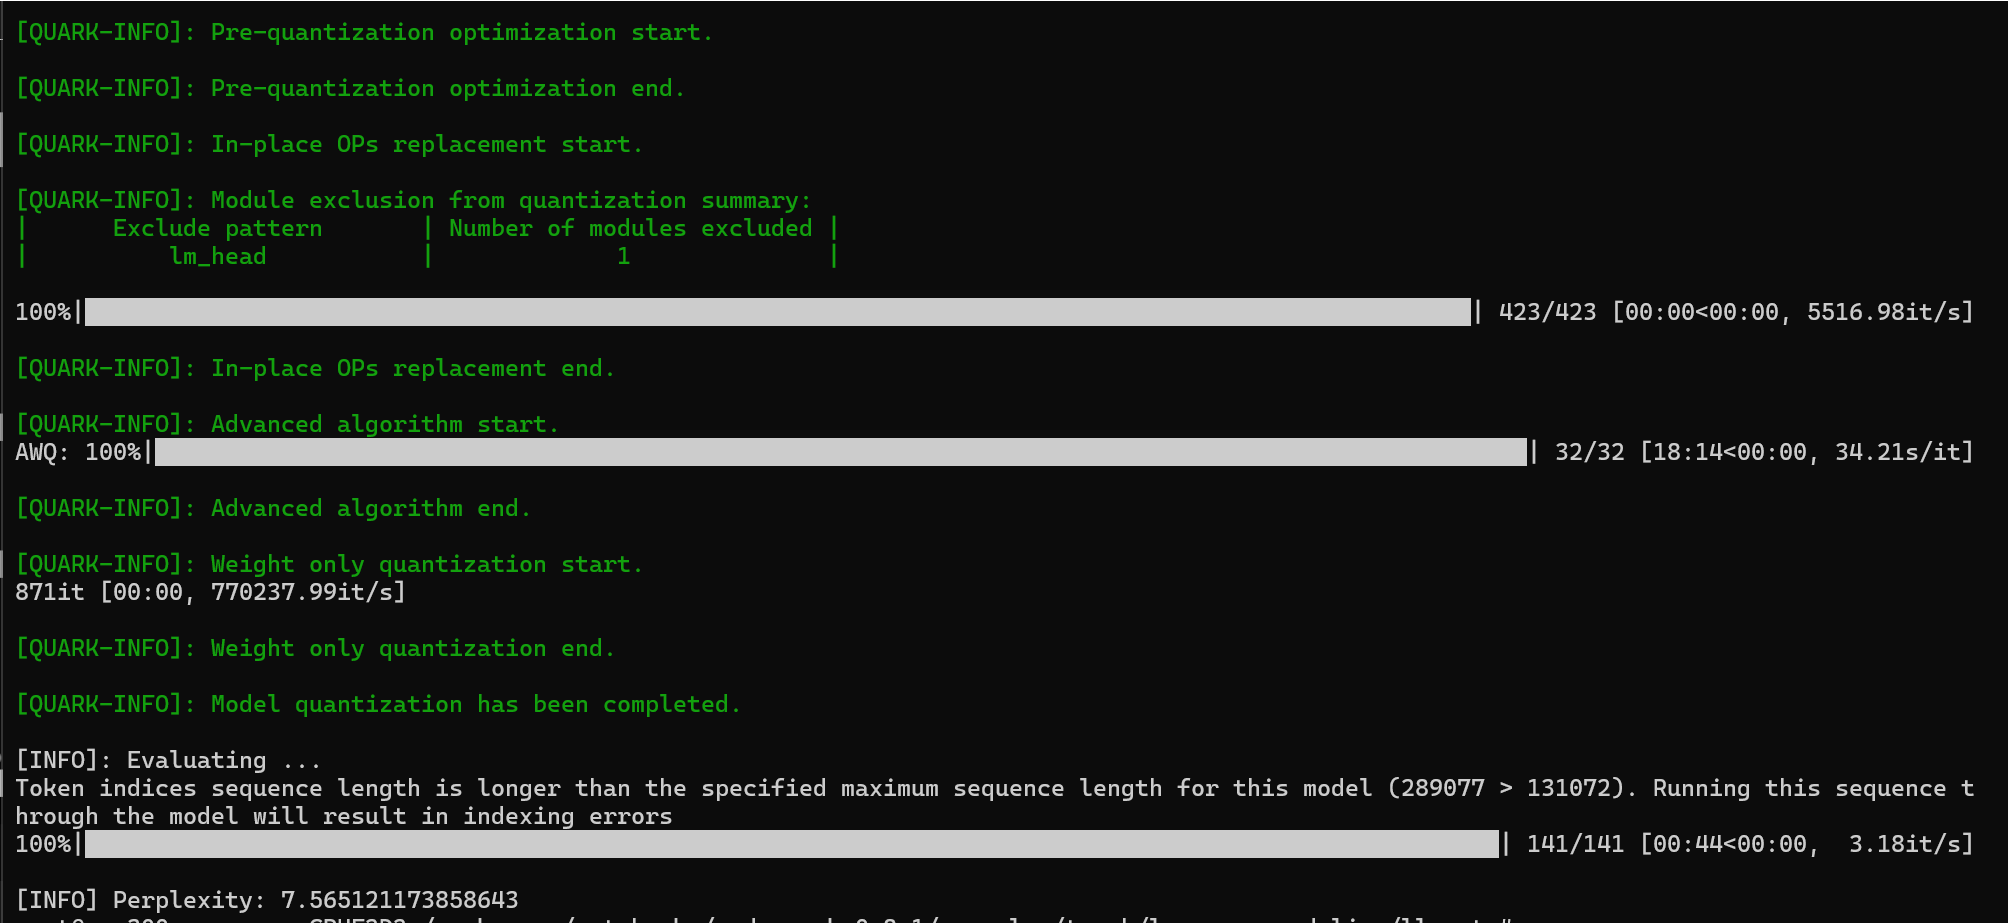

## Try Different Quantization Schemes
Experimenting with various quantization schemes can help improve accuracy. But keep in mind that how to select a appropriate scheme depends on your specific requirement and hardware constraints.

### Key Quantization Schemes:

Weight-only vs. Weight-Activation Quantization: Activation quantization may lead to significant accuracy drop while weight-only quantization with extremely low bit-width may yield better results.

Quantization Granularity:

Weight quantization: Options include per-tensor, per-channel, or per-group quantization.

Activation quantization: Options include per-tensor or per-token quantization.

Dynamic vs. Static Quantization: For activation quantization, dynamic quantization often results in better accuracy than static quantization.

Symmetric vs. Asymmetric: Try experiment with symmetric or asymmetric quantization based on the model’s sensitivity to signed or unsigned values.

Data Types (Dtypes): AMD Quark supports several data types, including INT4, INT8, FP8, MX-FPX, FP16, and BFloat16. Choose proper data type that best balances accuracy and efficiency for your model.

KV Cache Quantization: Skipping KV cache quantization typically results in better performance. Try applying this approach to the entire KV cache or specific parts of it may lead to better accuracy.

If accuracy issues persist after applying above methods, please consider trying AMD Quark’s debug tool to identify outlier layers and exclude them from quantization.